# 4. LCA With Real Data

Now that we are familiar with most of the terminology, we should move on to generate an LCA on REAL big databases. This notebook is based on [*Getting Started with Brightway2*](https://github.com/brightway-lca/brightway2/blob/master/notebooks/Getting%20Started%20with%20Brightway2.ipynb).

At the end of the notebook you will be able to:

* Import basic data like the biosphere database (this one gives you emision and resource flows!)
* Import and explore the [FORWAST](http://forwast.brgm.fr/Overview.asp) database, dowload [here](https://lca-net.com/projects/show/forwast/)

Chris Mutel promises a kitten when you finish the notebook. In this notebook is a surprise!


### Import packages and create a project

You know how this works, let's get to it!

In [1]:
from brightway2 import *

In [2]:
projects.set_current('Tut_4_RealLCA')

### Basic data!

Let's import some basic data - a database of elementary flows, some LCIA methods, and some metadata used for importing other databases. These are inside Brightway2, so you don't need to download anything whohoo!

Running `bw2setup()` might take some time! Depending on your machine :D

In [3]:
bw2setup()

Biosphere database already present!!! No setup is needed


### Biosphere

The `'biosphere3'` database was installed with `bw2setup()`. It is called the biosphere3 database because elementary flow names are normalized to the ecoinvent 3 standard.

Let's see how many flows there are in this database, and then look at one random flow:

In [4]:
db = Database("biosphere3")
print("Number of flows in `biosphere3`:", len(db))
random_flow = db.random()
print(random_flow)

Number of flows in `biosphere3`: 4427
'Methyl borate' (kilogram, None, ('air',))


In [5]:
print(random_flow['name'])
print(random_flow['unit'])
print(random_flow['categories'])

Methyl borate
kilogram
('air',)


Brightway2 uses keys to identify datasets. Each dataset is identified by a combination of its database and some unique code. The code can be anything - a number, a UUID, or just a name. All of the following would be valid key codes:
```{python}
    ("biosphere", "f66d00944691d54d6b072310b6f9de37")
    ("my new database", "building my dream house")
    ("skynet", 14832)
```

In [6]:
random_flow.key

('biosphere3', '971246f7-14d9-4ad5-98da-fc147dd8800f')

When you are looking for a specific flow, it is better to idectify it by its `code` rather than the `name`. A `name` can point at numerous flows, but the `code` is unique to just one flow.

### An LCIA method dataset

With `bw2setup()` we also installed a large number of LCIA methods:

In [7]:
len(methods)

975

Because LCIA methods have many different impact categories, they are identified not by a single label, but by a list of labels. Let's look at an example:

In [8]:
method_key = methods.random()
method_key

('EDIP (superseded)', 'resource consumption', 'renewable resources, wood')

In this case, the LCIA method has three levels of specificity, from the general method name (first level) to the specific impact category (last level). There is nothing magic about three levels - you could have one, or one hundred - but Brightway2 expects that LCIA methods will be a list of text labels `('like', 'this')`.

Note that method identifiers need to be a special kind of list that uses () instead of []. These are called tuples. To create a tuple with only one element, you need to add a comma, to distinguish it from a set of parentheses:

In [9]:
print (1 + 2)           # This is not a tuple
print (1,), type((1,))  # This is a tuple with one element

3
1


(None, tuple)

Let's now look at the method data. Method data has the format:
```{python}
biosphere flow, numeric value, location
```
Where:

* `biosphere flow` is a dataset from any database which is used as a biosphere flow.
* `numeric value` can be either a fixed number or an uncertainty distribution.
* `location` is optional; the default value is that this characterization factor is valid everywhere.

The method data format is pretty flexible, and the following are all acceptable:
```
[('biosphere', 'CO2'), 1.0],                                             # Default location
[('biosphere', 'CO2'), 1.0, 'Australia, mate!'],                         # Custom location
[('biosphere', 'CO2'), 1.0, ('Population density', 'Raster cell 4,2')],  # Location inside a geocollection
[('biosphere', 'CO2'), {'amount': 1.0, 'uncertainty type': 0}],          # Uncertain characterization factor
```

[Geocollections](https://brightway2-regional.readthedocs.io/#spatial-scales-geocollections) are needed for regionalized LCA.

If you are wondering why we need to identify biosphere flows like `('biosphere', '2fe885840cebfcc7d56b607b0acd9359')`, this is a good question! The short answer is that there is no single field that uniquely identifies biosphere flows or activities. The longer answer is in the [manual](https://2.docs.brightway.dev/intro.html#uniquely-identifying-activities).

Brightway2 is designed to be flexible enough for many different problems. Therefore, there are no limits on what constitutes a biosphere flow. Rather, anything that is linked to in a biosphere exchange will be put in the biosphere matrix. We installed a database called `biosphere3`, but you can define new flows in a database alongside process datasets, or create your own biosphere database.

Ok let's look at that method data now! This is also what it's called 


In [10]:
method_data = Method(method_key).load()
print("Number of CFs:", len(method_data))
method_data[:20]

Number of CFs: 4


[(('biosphere3', 'bac875f4-75fb-4dde-841a-b07d3a41bcd1'), 1),
 (('biosphere3', '28528881-7154-48d5-9cc3-5c13ddcdc47a'), 1),
 (('biosphere3', 'b073ec00-a5bf-4b64-bda0-ef366a3ac9bb'), 1),
 (('biosphere3', '23e83c1f-07c9-4b5f-a898-0f4f09a6691f'), 1)]

### Importing the FORWAST LCI database

We will use the FORWAST database, as it is both a high quality, comprehensive LCI database, and freely available. [FORWAST](http://forwast.brgm.fr/Overview.asp) is a physical MRIO table for Europe. It can be downloaded directly from the [2.-0 website](https://lca-net.com/projects/show/forwast/).

The following cell will download and install the FORWAST database. Note that an internet connection is required.

In [92]:
import zipfile
import os
from bw2data.utils import download_file
from pathlib import Path

In [96]:
## I commented this because I already donwloaded it!
# filepath = download_file("forwast.bw2package.zip", url="http://lca-net.com/wp-content/uploads/")
# dirpath = os.path.dirname(filepath)
# zipfile.ZipFile(filepath).extractall(dirpath)
# BW2Package.import_file(os.path.join(dirpath, "forwast.bw2package"))


### Searching datasets

By default, every database is added to a search engine powered by [Whoosh](https://whoosh.readthedocs.io/en/latest/intro.html). Searching covers the following data fields:

* `name`
* `comment`
* `product`
* `categories`
* `location`

Searching is done by using the `Database.search` method.

In [13]:
Database("forwast").search("food")

['_26 Food preparations n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_26 Food preparations n.e.c., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '100 Waste treatment, Biogasification of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '109 Waste treatment, Biogasification of food waste, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_92 Waste treatment, Incineration of waste, Food, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '101 Waste treatment, Incineration of waste, Food, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '103 Waste treatment, Composting of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '116 Waste treatment, Landfill of waste, Food, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '107 Waste treatment, Landfill of waste, Food, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '112 Waste treatment, Composting of food waste, EU27' (kilogram, GLO, ['Input Output', 

Searches can also be filtered—where only the results that meet the specified criteria are *included*,  or masked—where results that meet the specified criteria are *excluded*.

By default we return 25 search results, but this can be changed by specifying the `limit` keyword argument.

You can also use `*` wild cards in search queries:

In [14]:
Database("biosphere3").search("carb*", limit=10)

['Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'low population density, long-term')),
 'TOC, Total Organic Carbon' (kilogram, None, ('water', 'ground-')),
 'Carbon disulfide' (kilogram, None, ('air',)),
 'Carbon disulfide' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'DOC, Dissolved Organic Carbon' (kilogram, None, ('water', 'surface water')),
 'Carbon monoxide, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Lithium carbonate' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon disulfide' (kilogram, None, ('air', 'urban air close to ground')),
 'Boron carbide' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Organic carbon' (kilogram, None, ('soil',))]

You can specify inclusion or exclusion criteria for fields with `filter` and `mask`:

In [15]:
Database("biosphere3").search("carbon", filter={"categories": 'forestry'})

Excluding 79 filtered results


['Carbon' (kilogram, None, ('soil', 'forestry')),
 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil', 'forestry'))]

In [16]:
Database("biosphere3").search("carbon", limit=10, mask={"categories": 'forestry'})

Excluding 2 filtered results


['Carbon' (kilogram, None, ('soil', 'agricultural')),
 'Carbon' (kilogram, None, ('soil',)),
 'Carbon' (kilogram, None, ('soil', 'industrial')),
 'Carbon disulfide' (kilogram, None, ('air',)),
 'Carbon disulfide' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon disulfide' (kilogram, None, ('air', 'urban air close to ground')),
 'Organic carbon' (kilogram, None, ('soil',)),
 'Carbon-14' (kilo Becquerel, None, ('air', 'urban air close to ground')),
 'Carbon disulfide' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Organic carbon' (kilogram, None, ('air', 'urban air close to ground'))]

Finally, you can facet search results by another field. This is a bit complicated, so test your queries before assuming certain behaviour.

In [17]:
sr = Database("biosphere3").search("carbon", facet="categories")
for key, value in sr.items():
    print("Facet term:", key, "\n\t", value[:2], "\n")

Facet term: term 
	 ['Carbon-14' (kilo Becquerel, None, ('air', 'low population density, long-term')), 'Carbon disulfide' (kilogram, None, ('air', 'low population density, long-term'))] 

Facet term: water 
	 ['Organic carbon' (kilogram, None, ('water', 'ground-')), 'Elemental carbon' (kilogram, None, ('water',))] 

Facet term: air 
	 ['Carbon disulfide' (kilogram, None, ('air',)), 'Carbon-14' (kilo Becquerel, None, ('air',))] 

Facet term: urban 
	 ['Carbon disulfide' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Carbon disulfide' (kilogram, None, ('air', 'urban air close to ground'))] 

Facet term: soil 
	 ['Carbon' (kilogram, None, ('soil', 'agricultural')), 'Carbon' (kilogram, None, ('soil',))] 

Facet term: upper 
	 ['Carbon disulfide' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')), 'Carbon-14' (kilo Becquerel, None, ('air', 'lower stratosphere + upper troposphere'))] 

Facet term: resource 
	 ['Carbon dioxide, in air' (kilogram, None, ('nat

### Changing iteration order

You can also change the way that processes are iterated over in the database. The default order is random:

In [18]:
db = Database("forwast")

def print_10(db):
    for i, x in enumerate(db):
        if i < 10:
            print(x)
        else:
            break
            
print_10(db)

'_49 Bricks, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_96 Waste treatment, Incineration of waste, Glass' (kilogram, inert, DK, ['Input Output', 'Denmark 2003'])
'116 Waste treatment, Landfill of waste, Textiles, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_84 Real estate services, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])
'_19 Meat products, Fish, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'122 Recreational and cultural services, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])
'_51 Bricks, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'_32 Wood products, except furniture, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'_40 Fertiliser, other than N, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'132 Household use, Security, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])


You can sort by `location`, `name`, `product` (reference product), or `type`, by specifying the `order_by` property.

In [19]:
db.order_by = "name"
print_10(db)

'100 Health and social work, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'100 Waste treatment, Biogasification of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'101 Waste treatment, Biogasification of paper, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'101 Waste treatment, Incineration of waste, Food, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'102 Waste treatment, Biogasification of sewage slugde, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'102 Waste treatment, Incineration of waste, Paper, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'103 Waste treatment, Composting of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'103 Waste treatment, Incineration of waste, Plastic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'104 Waste treatment, Composting of paper and wood, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'104 Waste treatment, Incineration of waste, Metals, EU27' (kilogram, GLO, [

If the above seems wrong, remember that the names start with `100`, `101`, etc.

Set `.order_by = None` to remove any ordering.


In [20]:
db.order_by = None

Because accessing activities in the database is quite fast, you can also filter the activities you want by just iterating over the entire database:

In [21]:
my_activities = [x for x in db if 'Electr' in x['name']]
my_activities

['_59 Electrical machinery n.e.c., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '_75 Electricity, steam and hot water, EU27' (kilowatt hour, GLO, ['Input Output', 'EU27 2003']),
 '_68 Electrical machinery n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_66 Electricity, steam and hot water, DK' (kilowatt hour, GLO, ['Input Output', 'Denmark 2003'])]

### Basic LCA calculations

Let's pick a process and LCIA method. The original tutorial uses random everything and I was unlucky enough that my LCA score was 0. Let's try to select specific processes and methods. The next [notebook](BW_Tutorial_5_Calculation_Setups.ipybn) will show how to select a non-zero random method. For now, I just place one that I know it works.

In [28]:
process = Database('forwast').random()
print(process)
method_key = ('EDIP (superseded)',
 'environmental impact',
 'photochemical ozone formation, low NOx POCP')
print(method_key)



'_99 Waste treatment, Incineration of waste, Oil' (kilogram, Hazardous waste, DK, ['Input Output', 'Denmark 2003'])
('EDIP (superseded)', 'environmental impact', 'photochemical ozone formation, low NOx POCP')


*A brief review of LCA calculations:*

In matrix-based LCA, we construct a **technosphere matrix**, which describes the inputs needed to produce different products (e.g. cars need metal and electricity), and a **biosphere matrix**, which describes the emissions and resource consumption associated with the production of each product (e.g. car manufacturing releases air emissions). These two matrices come from the life cycle inventory database(s). We also have a **functional unit**, which is what we are trying to assess, e.g. one car. 

So, to calculate the **life cycle inventory (LCI)** we need to (1) solve the linear system of the technosphere matrix and the functional unit, and (2) multiply it by the biosphere matrix.

To do **life cycle impact assessment (LCIA)**, we multiply the life cycle inventory by a **matrix of characterization factors**, which tell how bad different emissions and resource consumptions are.

For more details on the math, see the [manual](https://2.docs.brightway.dev/lca.html).

So, our first step is to specify the **functional unit**, which is relatively easy:


In [29]:
functional_unit = {process: 1}

We can then instantiate our LCA object.

In [30]:
lca = LCA(functional_unit, method_key)

And do the LCI and LCIA calculations:

In [31]:
lca.lci() # This one adjusts matrixes to their functional unit
lca.lcia() # This onemultiplies the LCI with the characterization factors



Finally, we can print the LCA score:


In [32]:
lca.score

0.001006725219267726

You can reuse the same matrices but change the functional unit by using the `redo_lci` and `redo_lcia` functions:

In [33]:
new_process = Database("forwast").random()
print(new_process)
lca.redo_lcia({new_process: 1})
lca.score

'_52 Recycling of bricks, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


-0.00011801743281960755

### Looking into the LCA object

Looking into the LCA object. Wrap the following lines to see the items printed. If you want more detailed explanation of what these matrices mean, refer to the *Massimo Tutorial 1* found in the folder *BW2_Massimo_Tutorial*.

In [46]:
lca.inventory # This is incomplete in the original notebook, I decided to see the inventory object.

<20x277 sparse matrix of type '<class 'numpy.float64'>'
	with 1119 stored elements in Compressed Sparse Row format>

Let's see what is in this LCA thing, anyway.

* The technosphere matrix

In [47]:
lca.technosphere_matrix

<277x277 sparse matrix of type '<class 'numpy.float64'>'
	with 36825 stored elements in Compressed Sparse Row format>

* The biosphere matrix

In [48]:
lca.biosphere_matrix

<20x277 sparse matrix of type '<class 'numpy.float64'>'
	with 2170 stored elements in Compressed Sparse Row format>

* The characterization matrix

In [49]:
lca.characterization_matrix

<20x20 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

### Graphing matrices

To further understand what we just did, let's visualize the calculation results.

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

There might be warnings here, but you can ignore them.

In [60]:
from bw2analyzer.matrix_grapher import SparseMatrixGrapher

First, let's look at the technosphere matrix.

You can pass in a filename to get a higher resolution figure saved as a file.

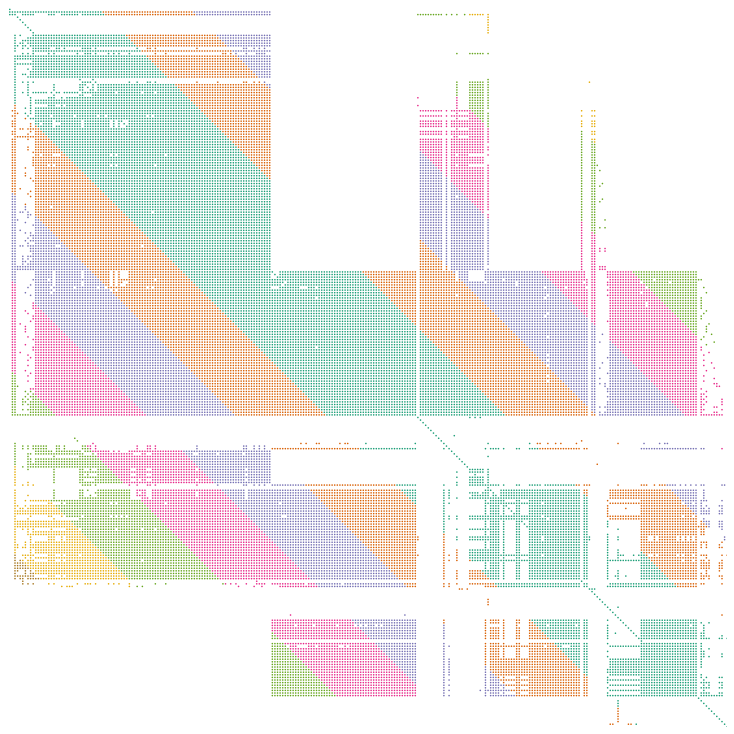

In [68]:
SparseMatrixGrapher(lca.technosphere_matrix).ordered_graph(width=10, height=10)

Not so interesting - I am sure your inventory data will be much nicer. The problem is that this is an IO matrix, so there is a value at each point, even if it is small, and this graph only shows where values are or aren't zero. 

### Contribution analysis

We can calculate the most important activities and biosphere flows.

In [71]:
from bw2analyzer import ContributionAnalysis

Most important activities.

In [84]:
ContributionAnalysis().annotated_top_processes(lca)

[(-5.3095309870084506e-05,
  -0.011894983002060211,
  '_85 Land transport and transport via pipelines, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])),
 (-6.12683633571238e-06,
  -0.004570714884753643,
  '_53 Iron basic, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-6.010324454684616e-06,
  -0.011934944869403422,
  '_43 Chemicals n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-5.6881546186831765e-06,
  -1.2072045395442388,
  '_17 Clay and soil from quarry, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-4.835119336914352e-06,
  -0.0041064644814119405,
  '_39 Fertiliser, N, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-4.740635631271696e-06,
  -0.2704734540776666,
  '_75 Electricity, steam and hot water, EU27' (kilowatt hour, GLO, ['Input Output', 'EU27 2003'])),
 (-2.962474111839507e-06,
  -0.02727094908628054,
  '_37 Refined petroleum products and fuels, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-2.9499546

Most important biosphere flows:

In [81]:
ContributionAnalysis().annotated_top_emissions(lca)

[(-7.612464649427483e-05,
  -0.00019031161339982302,
  'NMVOC, non-methane volatile organic compounds, unspecified origin' (kilogram, None, ('air',))),
 (-3.9083256241866516e-05,
  -0.0009770814278861344,
  'Carbon monoxide, fossil' (kilogram, None, ('air',))),
 (-2.8095300834661823e-06,
  -0.00040136142810646974,
  'Methane, fossil' (kilogram, None, ('air',))),
 (0.0,
  -0.00046070512691766236,
  'Aluminium, in ground' (kilogram, None, ('natural resource', 'in ground'))),
 (0.0,
  -1.1804277590503638,
  'Sand, unspecified, in ground' (kilogram, None, ('natural resource', 'in ground'))),
 (0.0,
  -0.043958130947490605,
  'Coal, hard, unspecified, in ground' (kilogram, None, ('natural resource', 'in ground'))),
 (0.0,
  -5.662776657140794e-05,
  'Copper, 1.13% in sulfide, Cu 0.76% and Ni 0.76% in crude ore, in ground' (kilogram, None, ('natural resource', 'in ground'))),
 (0.0,
  -0.02404910276045318,
  'Gas, natural, in ground' (cubic meter, None, ('natural resource', 'in ground'))),
 

In [82]:
len(ContributionAnalysis().annotated_top_emissions(lca))

20

### Monte Carlo LCA

Unfortunately, the FORWAST database doesn't include uncertainty. Let's put some in anyways, using the utility function `uncertainify`.

In [85]:
from bw2data.utils import uncertainify
from stats_arrays import NormalUncertainty

In [86]:
uncertain_db = Database("forwast uncertain +")
uncertain_db.write(
    uncertain_db.relabel_data(
        uncertainify(
            Database("forwast").load(), 
            NormalUncertainty
        ), 
        "forwast uncertain +" 
    )
)

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 08/08/2022 09:32:40
  Finished: 08/08/2022 09:32:41
  Total time elapsed: 00:00:01
  CPU %: 2.10
  Memory %: 1.17


We can now calculate some Monte Carlo iterations for a random activity.

In [87]:
mc = MonteCarloLCA(demand={uncertain_db.random(): 1}, method=method_key)
mc.load_data()
for x in range(10):
    print(next(mc))

0.0034398127370235472
0.0031623663577565178
0.0034585946743614744
0.0035780230560005064
0.0034389559588257758
0.0034456603129055627
0.003361543455890633
0.0035227455422494223
0.0033838661523272707
0.003620000560289965


That's it! Here is your surprise! 

In [89]:
from IPython.display import Image
dimensions = sorted((int(random.random() * 600 + 200), int(random.random() * 600 + 200)))
Image(url="https://magazine.washington.edu/columns_wordpress/wp-content/uploads/2018/06/Narwhal375.jpg")

It is not a kitten. I know. But this is  narwhal. Narwhals are the unicorns of the sea. Have a wonderful day.

Ok. Here is also a kitten.

In [90]:
dimensions = sorted((int(random.random() * 600 + 200), int(random.random() * 600 + 200)))
Image(url="http://placekitten.com/{}/{}/".format(*dimensions))